In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# XGBoost, LightGBM, Catboost топовые бустинги

<img src='https://alkogolizm.net/images/gipertoniya.jpg'>

## 1. Получите данные и загрузите их в рабочую среду.

In [28]:
#!pip install kagglehub

In [29]:
!wget 'https://docs.google.com/uc?export=download&id=1BJotllh9u288YzyqOdUzulQIiruuypPb' -O heart.csv   # Загрузка с моего гугл-диска
# The original link downloads a webpage not the raw csv.
# This updated command downloads the raw csv file using the 'export=download' parameter
# and saves it as 'heart.csv' using the '-O' option.

df = pd.read_csv('heart.csv')
df.head()

--2025-03-02 09:01:48--  https://docs.google.com/uc?export=download&id=1BJotllh9u288YzyqOdUzulQIiruuypPb
Resolving docs.google.com (docs.google.com)... 172.217.214.102, 172.217.214.113, 172.217.214.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1BJotllh9u288YzyqOdUzulQIiruuypPb&export=download [following]
--2025-03-02 09:01:48--  https://drive.usercontent.google.com/download?id=1BJotllh9u288YzyqOdUzulQIiruuypPb&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.193.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35921 (35K) [application/octet-stream]
Saving to: ‘heart.csv’

heart.csv           100%[===================>]  35.08K  --.-KB/s    in 

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [30]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load a DataFrame with a specific version of a CSV
df_kaggle = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "fedesoriano/heart-failure-prediction",
    "heart.csv",
)

In [31]:
df.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [32]:
# RestingBP - аномалии: кровяное давление не может быть в покое по нулям при условии что испытуемый живой
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [33]:
# У индекса 449 кровяное давление изменил на целое среднее значение = 133

In [34]:
df.loc[df['RestingBP'] == 0, ['RestingBP']]=np.ceil(np.mean(df['RestingBP']))

In [35]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.541394,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.989938,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## 2. Подготовьте датасет к обучению моделей.

### a) Категориальные переменные переведите в цифровые значения.

In [ ]:
"""
ChestPainType: тип ангинозной боли за грудиной: ['ATA', 'NAP', 'ASY', 'TA']:  ATA: атипичная боль,
                                                                              NAP: боль, не связанная с ишемией,
                                                                              ASY: асимптомная - безболевая форма ишемии,
                                                                              TA:  типичная болевая ишемия миокарда (стенокардия!)

RestingECG: результаты ЭКГ: ['Normal', 'ST', 'LVH']:  Normal: нормальная ЭКГ,
                                                      ST: наличие аномалили сегмента ST и зубца T (инверсия зубца T и/или элевация или депрессия сегмента ST более чем на 0.05)
                                                      LVH: признаки гипертрофии левого желудочка

ExerciseAngina:  грудная боль связанная с физической нагрузкой: да, нет

ST_Slope: изменения сегмента ST: Up: подъём сегмента ST,
                                 Flat: сегмент ST на изолинии,
                                 Down: депрессия сегмента ST
"""

In [37]:
categorical_column = df.select_dtypes(include='object').columns# категориальные номинативные признаки
categorical_column

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [38]:
import sklearn.preprocessing
LE, ONE  = sklearn.preprocessing.LabelEncoder(), sklearn.preprocessing.OneHotEncoder()

In [39]:
df_cod = pd.get_dummies(df, columns=categorical_column, dtype='int')

In [40]:
df_cod.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


### б) Постройте 1-2 графика на выбор

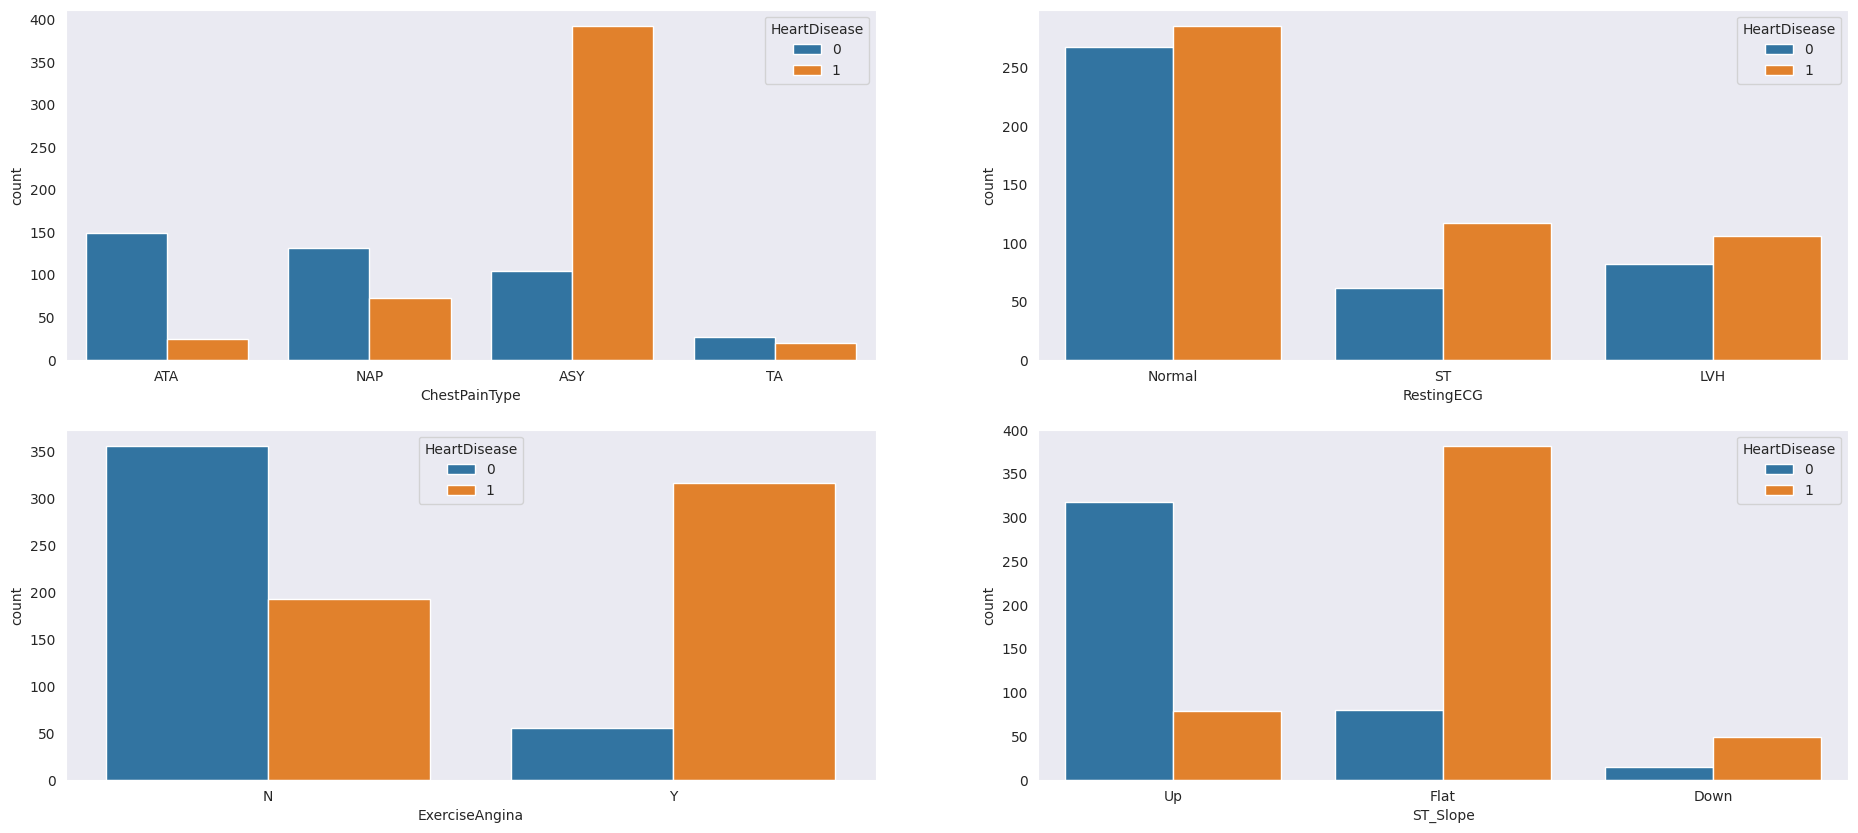

In [41]:
sns.set_style('dark')
plt.figure(figsize=(23, 10))
plt.subplot(2,2,1)
sns.countplot(data=df, x='ChestPainType', hue='HeartDisease')
plt.subplot(2,2,2)
sns.countplot(data=df, x='RestingECG', hue='HeartDisease')
plt.subplot(2,2,3)
sns.countplot(data=df, x='ExerciseAngina', hue='HeartDisease')
plt.subplot(2,2,4)
sns.countplot(data=df, x='ST_Slope', hue='HeartDisease');

У ПРИЗНАКОВ НЕТ ЯВНОЙ КОРРЕЛЯЦИЙ


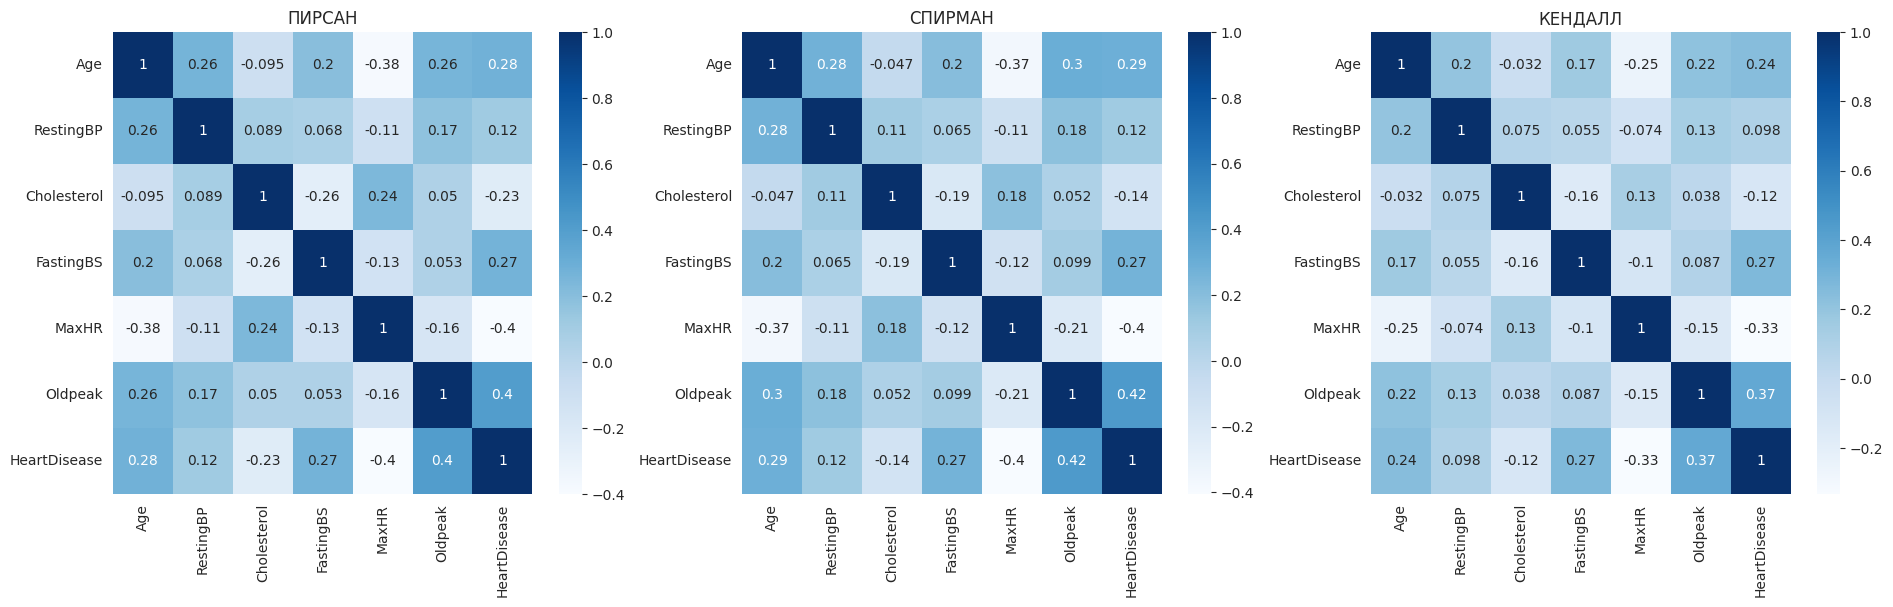

In [323]:
print('у признаков нет явной корреляций'.upper())
data_c=df.drop(labels=categorical_column, axis=1)
corr_ = data_c.corr()
corr_spearman = data_c.corr('spearman')
corr_kendall = data_c.corr('kendall')
plt.figure(figsize=(23, 6))
plt.subplot(1,3,1)
plt.title('ПИРСАН')
sns.heatmap(corr_, cmap='Blues', annot=True)
plt.subplot(1,3,2)
plt.title('СПИРМАН')
sns.heatmap(corr_spearman, cmap='Blues', annot=True)
plt.subplot(1,3,3)
plt.title('КЕНДАЛЛ')
sns.heatmap(corr_kendall, cmap='Blues', annot=True);

## 3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [43]:
from sklearn.model_selection import  train_test_split

In [44]:
x=df_cod.drop(labels='HeartDisease', axis=1)
y=df_cod['HeartDisease']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1982, stratify=y, test_size=0.2)

## 4. Обучите дерево решений на обучающем множестве. Используйте следующие модели:

a.tree.DecisionTreeClassifier

b.ensemble.RandomForestClassifier

In [45]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth=10, min_samples_split=15, random_state=1982)

In [81]:
from sklearn.ensemble import RandomForestClassifier
randforest_class_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=15, random_state=1982)

In [61]:
def matrix_(x, y, model=DecisionTreeClassifier()):
  x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, random_state=1982, stratify=y, test_size=0.2)
  model.fit(x_train_, y_train_)
  y_pred_ = model.predict(x_test_)
  print(f'МАТРИЦА ОШИБОК НА ТЕСТОВОЙ ВЫБОРКЕ')
  print(f'наличие болезни сердца: {y_test_.value_counts()[0]}')
  print(f'отсутствие болезни сердца: {y_test_.value_counts()[1]}')
  matrix=metrics.confusion_matrix(y_test_, y_pred_)
  sns.heatmap(matrix, cmap='Blues', annot=True)
  plt.xlabel('y_pred')
  plt.ylabel('actual');

In [203]:
# ОТЧЁТ КЛАССИФИКАТОРА
def classification_report(x, y, model, selection='тестовой'):
  x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, random_state=1982, stratify=y, test_size=0.2)
  model.fit(x_train_, y_train_)
  y_pred_test = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  if selection == 'тестовой':
    print(f'На {selection} выборке')
    print(metrics.classification_report(y_test, y_pred_test))
  else:
    print(f'На {selection} выборке')
    print(metrics.classification_report(y_train, y_pred_train))

In [47]:
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=15, random_state=1982)

In [82]:
randforest_class_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=15, random_state=1982)

In [48]:
y_pred_train_tree_model = tree_model.predict(x_train)
y_pred_test_tree_model = tree_model.predict(x_test)

In [83]:
y_pred_train_randforest_model = randforest_class_model.predict(x_train)
y_pred_test_randforest_model = randforest_class_model.predict(x_test)

## 5. Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report

In [208]:
# ДЕРЕВО РЕШЕНИЙ
classification_report(x, y, DecisionTreeClassifier(max_depth=10, min_samples_split=15, random_state=1982))

На тестовой выборке
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        82
           1       0.84      0.78      0.81       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



In [207]:
classification_report(x, y, DecisionTreeClassifier(max_depth=10, min_samples_split=15, random_state=1982), selection="обучающей")

На обучающей выборке
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       328
           1       0.92      0.92      0.92       406

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



In [214]:
# СЛУЧАЙНЫЙ ЛЕС
classification_report(x, y, RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=15, random_state=1982))

На тестовой выборке
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [215]:
classification_report(x, y, RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=15, random_state=1982), selection="обучающей")

На обучающей выборке
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       328
           1       0.90      0.94      0.92       406

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



МАТРИЦА ОШИБОК НА ТЕСТОВОЙ ВЫБОРКЕ
наличие болезни сердца: 82
отсутствие болезни сердца: 102


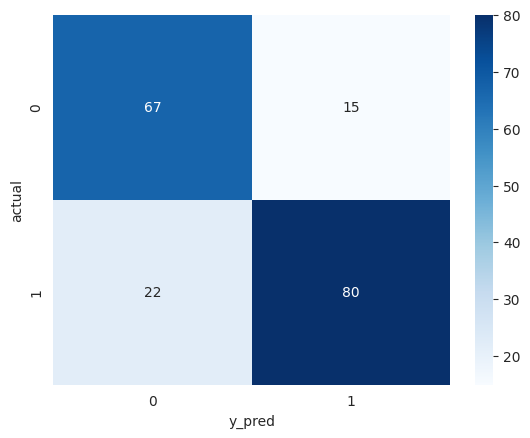

In [293]:
# МАТРИЦА ОШИБОК МОДЕЛИ ДЕРЕВО РЕШЕНИЙ
matrix_DecisionTree = matrix_(x=x, y=y, model=DecisionTreeClassifier(random_state=1982, max_depth=10, min_samples_split=15))

МАТРИЦА ОШИБОК НА ТЕСТОВОЙ ВЫБОРКЕ
наличие болезни сердца: 82
отсутствие болезни сердца: 102


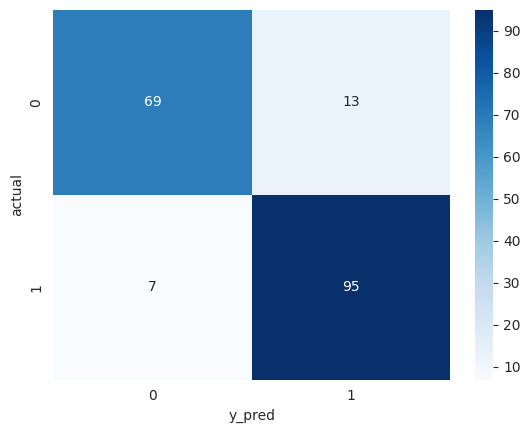

In [292]:
# МАТРИЦА ОШИБОК МОДЕЛИ СЛУЧАЙНЫЙ ЛЕС (беггинг+случайное пространство)
matrix_RandomForest = matrix_(x=x, y=y, model=RandomForestClassifier(n_estimators=100, random_state=1982, max_depth=10, min_samples_split=15))

## 6. Выведите важность признаков, полученную после обучения модели из п. 4b в виде столбчатой диаграммы. Отсортируйте важность по убыванию

In [150]:
def chart_feature_importances(fit_model, x_test):
  df_feature_importances = pd.DataFrame({'feature': x_test.columns, 'weights': fit_model.feature_importances_}).sort_values(by='weights', ascending=False)
  plt.figure(figsize=(12, 7))
  sns.barplot(data=df_feature_importances, x='weights', y='feature', hue='weights', palette='OrRd') # palette='BuGn'

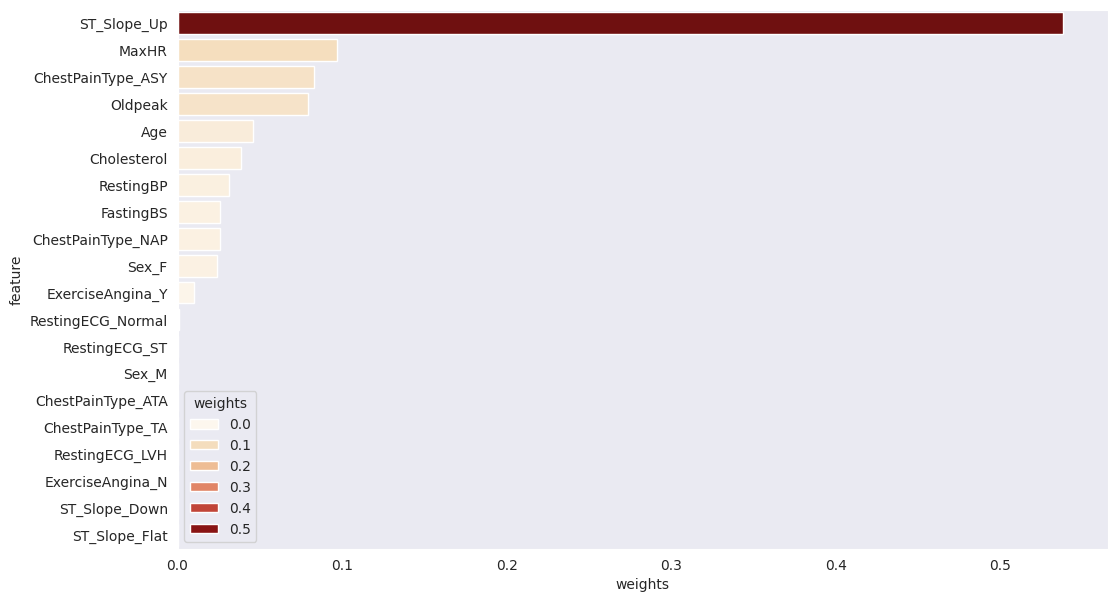

In [151]:
# Важность признаков модели ДЕРЕВО РЕШЕНИЙ
chart_feature_importances(tree_model, x_test)

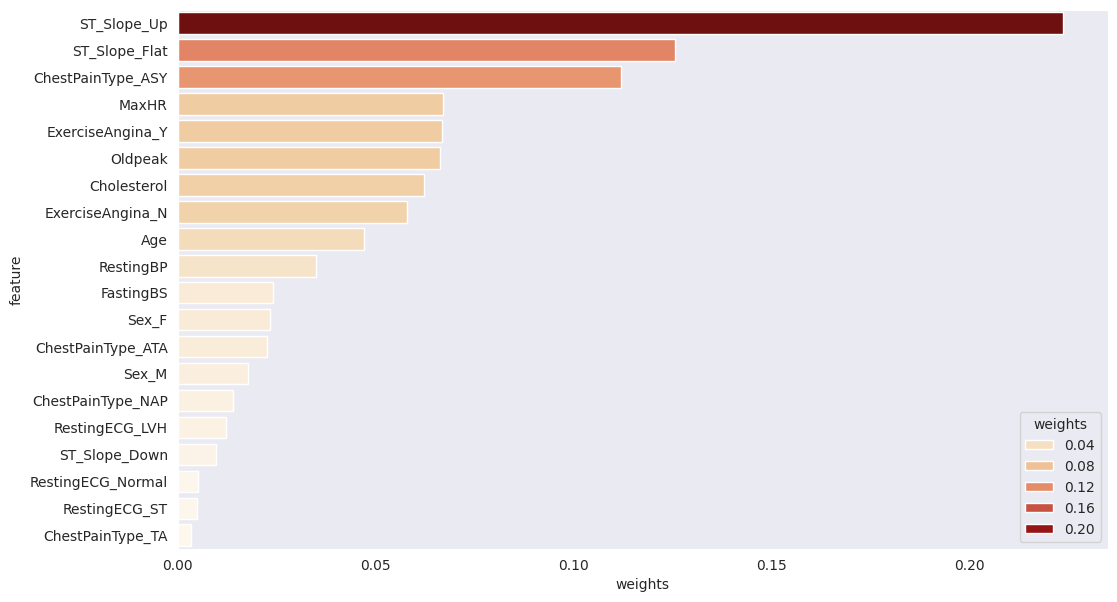

In [152]:
# Важность признаков модели СЛУЧАЙНЫЙ ЛЕС
chart_feature_importances(randforest_class_model, x_test)

## 7. Обучите бэггинг над моделью из п. 4a. Используйте ensemble.BaggingClassifier.

In [188]:
from sklearn.ensemble import BaggingClassifier

МАТРИЦА ОШИБОК НА ТЕСТОВОЙ ВЫБОРКЕ
наличие болезни сердца: 82
отсутствие болезни сердца: 102


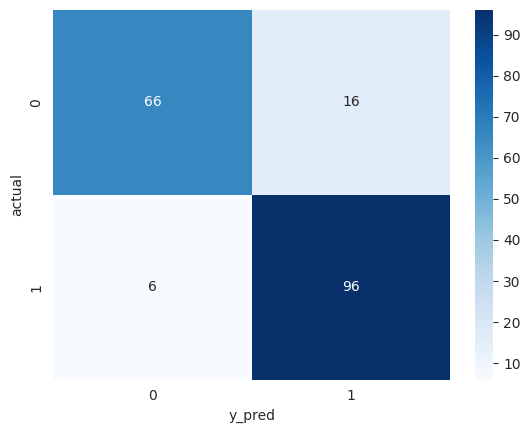

In [291]:
# Удалось снизить FN до 6 - ошибку первого рода!
matrix_Bagging = matrix_(x=x, y=y, model=BaggingClassifier(n_estimators=150, random_state=1982, max_features=5, max_samples=10))

In [205]:
classification_report(x=x, y=y, model=BaggingClassifier(n_estimators=150, random_state=1982, max_features=5, max_samples=10))

На тестовой выборке
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        82
           1       0.86      0.94      0.90       102

    accuracy                           0.88       184
   macro avg       0.89      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184



## 8. Обучите стекинг трех моделей: из п. 4a, п. 4b и svm.LinearSVC. Используйте ensemble.StackingClassifier.

In [195]:
randforest_class_model

RandomForestClassifier(max_depth=10, min_samples_split=15, random_state=1982)

In [196]:
tree_model

DecisionTreeClassifier(max_depth=10, min_samples_split=15, random_state=1982)

In [217]:
from sklearn.svm import LinearSVC

In [220]:
#Отчёт для модели LinearSVC
classification_report(x, y, LinearSVC())

На тестовой выборке
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



In [221]:
classification_report(x, y, LinearSVC(), selection="обучающей")

На обучающей выборке
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       328
           1       0.86      0.90      0.88       406

    accuracy                           0.87       734
   macro avg       0.87      0.86      0.86       734
weighted avg       0.87      0.87      0.86       734



МАТРИЦА ОШИБОК НА ТЕСТОВОЙ ВЫБОРКЕ
наличие болезни сердца: 82
отсутствие болезни сердца: 102


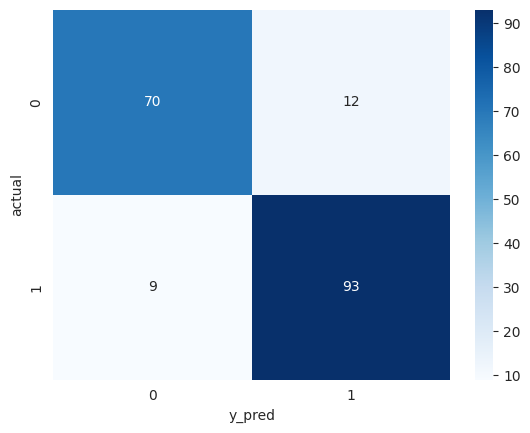

In [288]:
# Матрица ошибок для модели LinearSVC
matrix_LinearSVC = matrix_(x, y, LinearSVC())

In [223]:
from sklearn.ensemble import StackingClassifier

In [ ]:
tree_model, randforest_class_model, LinearSVC()

In [235]:
# СТЕКИНГ МОДЕЛЬ
stacking_model = StackingClassifier([('Дерево решений', tree_model),
                                     ('Случайный лес', randforest_class_model),
                                     ('Опорные вектора', LinearSVC())
                                    ])


In [238]:
stacking_model.named_estimators

{'Дерево решений': DecisionTreeClassifier(max_depth=10, min_samples_split=15, random_state=1982),
 'Случайный лес': RandomForestClassifier(max_depth=10, min_samples_split=15, random_state=1982),
 'Опорные вектора': LinearSVC()}

МАТРИЦА ОШИБОК НА ТЕСТОВОЙ ВЫБОРКЕ
наличие болезни сердца: 82
отсутствие болезни сердца: 102


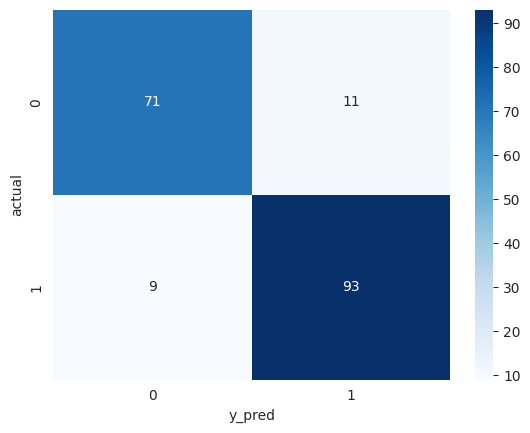

In [289]:
# Матрица ошибок для СТЕКИНГ МОДЕЛИ
matrix_stacking = matrix_(x, y, stacking_model)

In [296]:
#Отчёт для СТЕКИНГ МОДЕЛИ
classification_report(x, y, stacking_model)

На тестовой выборке
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



## БЕГГИНГ НАД БУСТИНГОМ

In [240]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [256]:
grad_mod = GradientBoostingClassifier(max_features=7, max_depth=10, min_samples_leaf=20)

In [257]:
mod_beg_bust = BaggingClassifier(grad_mod, n_estimators=100)

МАТРИЦА ОШИБОК НА ТЕСТОВОЙ ВЫБОРКЕ
наличие болезни сердца: 82
отсутствие болезни сердца: 102


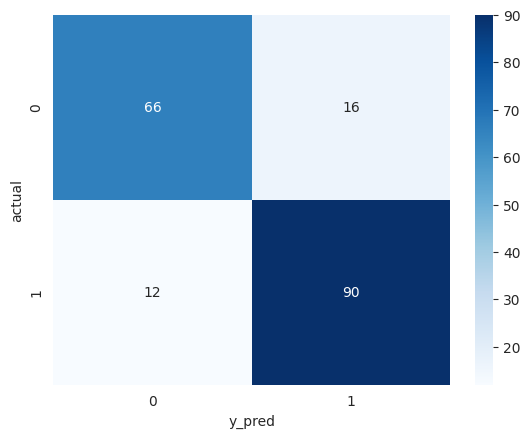

In [290]:
# Модель хуже и дольше работает
matrix_beg_bust = matrix_(x, y, mod_beg_bust)

In [298]:
#Отчёт Беггинг над Бустом
classification_report(x, y, mod_beg_bust)

На тестовой выборке
              precision    recall  f1-score   support

           0       0.84      0.79      0.82        82
           1       0.84      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



## 9. Сформулируйте выводы по проделанной работе.

In [303]:
models = ['DecisionTreeClassifier', 'RandomForestClassifier', 'BaggingClassifier', 'LinearSVC', 'Stacking_model', 'Bagging_Boost']

In [320]:
df_classification_report = pd.DataFrame({'precision': [0.84, 0.88, 0.86, 0.89, 0.89, 0.84], 'recall': [0.78, 0.93, 0.94, 0.91, 0.91, 0.88], 'f1-score': [0.81, 0.90, 0.90, 0.90, 0.90, 0.86], 'accuracy': [0.80, 0.89, 0.88, 0.89, 0.89, 0.84]},
                                        index=models).sort_values(by='recall', ascending=False)
print('Тестовые показатели для первого класса (есть заболевание сердца)'.upper())
df_classification_report

ТЕСТОВЫЕ ПОКАЗАТЕЛИ ДЛЯ ПЕРВОГО КЛАССА (ЕСТЬ ЗАБОЛЕВАНИЕ СЕРДЦА)


,precision,recall,f1-score,accuracy
BaggingClassifier,0.86,0.94,0.90,0.88
RandomForestClassifier,0.88,0.93,0.90,0.89
LinearSVC,0.89,0.91,0.90,0.89
Stacking_model,0.89,0.91,0.90,0.89
Bagging_Boost,0.84,0.88,0.86,0.84
DecisionTreeClassifier,0.84,0.78,0.81,0.80


In [321]:
df_matrix = pd.DataFrame({'TN': [67, 69, 66, 70, 71, 66], 'FN': [22, 7, 6, 9, 9, 12], 'TP': [80, 95, 96, 93, 93, 90], 'FP': [15, 13, 16, 12, 11, 16]},
                                        index=models).sort_values(by='FN')
print('Показатели матриц ошибок всех моделей'.upper())
df_matrix

ПОКАЗАТЕЛИ МАТРИЦ ОШИБОК ВСЕХ МОДЕЛЕЙ


,TN,FN,TP,FP
BaggingClassifier,66,6,96,16
RandomForestClassifier,69,7,95,13
LinearSVC,70,9,93,12
Stacking_model,71,9,93,11
Bagging_Boost,66,12,90,16
DecisionTreeClassifier,67,22,80,15


In [ ]:
# Ансамбли значительно превосходят модели с отдельным алгоритмом решения, ансамбли достигают более высокой точности, чем любая отдельная модель. Объединяя прогнозы нескольких моделей, ансамбли могут дать более точную оценку. Универсальность
# Наихудший результат на тестовых выборках показала модель ДЕРЕВО РЕШЕНИЙ даже при условиях оптимальных подборов гиперпараметров.
# Если сравнивать ансамбли, то модель ОПОРНЫХ ВЕКТОРОВ показал хороший результат.
# Вероятнее всего наиболее важным показателем для предсказания сердечного заболевания являтся FN (ошибка первого рода) и recall, считаю что наилучшем образом справилась модель BaggingClassifier
# Стекинг модель сложная и справилась несколько хуже модели СЛУЧАЙНЫХ ЛЕСОВ, почти одинаково с моделью опорных векторов.
# Беггинг над Бустом занимает предпоследнее место. Вероятнее всего требуются более грамотный подбор гиперпараметров. Может я чего намудрил.

In [ ]:
"""
ChestPainType: тип ангинозной боли за грудиной: ['ATA', 'NAP', 'ASY', 'TA']:  ATA: атипичная боль,
                                                                              NAP: боль, не связанная с ишемией,
                                                                              ASY: асимптомная - безболевая форма ишемии,
                                                                              TA:  типичная болевая ишемия миокарда (стенокардия!)

RestingECG: результаты ЭКГ: ['Normal', 'ST', 'LVH']:  Normal: нормальная ЭКГ,
                                                      ST: наличие аномалили сегмента ST и зубца T (инверсия зубца T и/или элевация или депрессия сегмента ST более чем на 0.05)
                                                      LVH: признаки гипертрофии левого желудочка

ExerciseAngina:  грудная боль связанная с физической нагрузкой: да, нет

ST_Slope: изменения сегмента ST: Up: подъём сегмента ST,
                                 Flat: сегмент ST на изолинии,
                                 Down: депрессия сегмента ST
"""

In [ ]:
# Итак, Самый важный признак: ST_Slope_UP - подъём сегмента ST - достоверный маркер протекающего в настоящий момент острого инфаркта миокарда, отражает окклюзию коронарной артии (ПКА, ОА, ПНА, ствол левой кор. артери..). ST_Slope_UP может при тяжёлых миокардитах.
# ST_Slope_flat - не понятно что создатели датасета подразумевали в данный признак. Но видно что модель случайного леса считает важным признаком, а вот Down менее, что является очень очень странным т.к ST_Slope_Down является признаком повреждения миокарда!
# ChestPainType_ASY - безболевая форма ишемии - коварный признак. Модель молодец.
# MaxНR - Максимальный пульс и ExerciseAngina - стенокардия при нагрузках, что говорит о наличии значимых стенозов в коронарных артериях - повышает риск развития инфаркта
# Oldpeak - так же наиважнейший признак - чем выше значение глубина/высота ST тем больше повреждения миокарда.

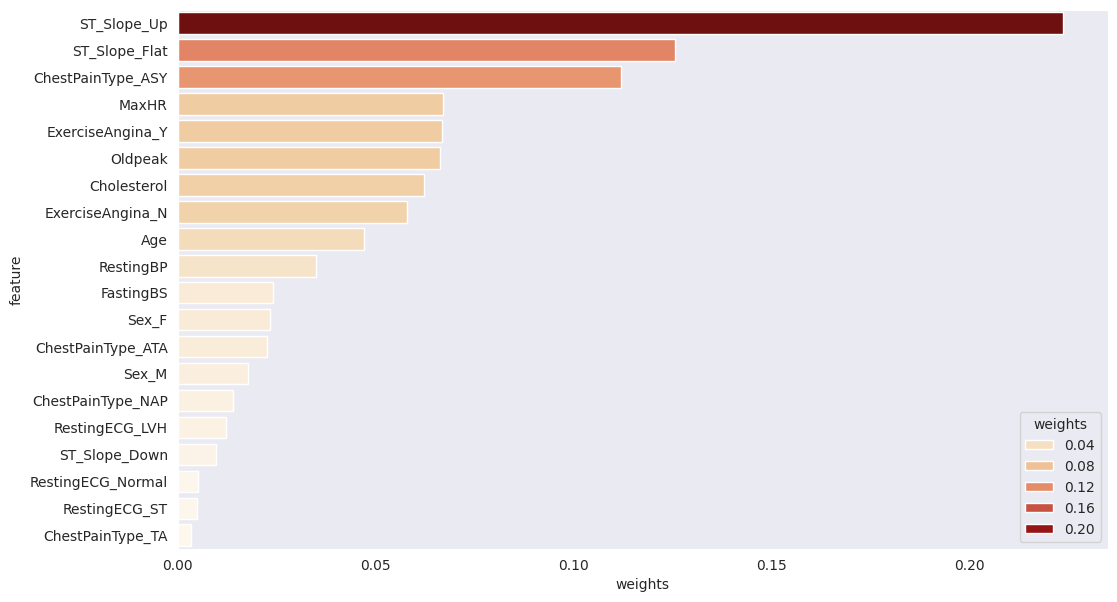

In [324]:
chart_feature_importances(randforest_class_model, x_test)